## Reconstructure

In [63]:
#GPU memory usage:
#23546MiB / 24263MiB

#requirements:
#pytorch-forecasting==0.9.0

In [64]:
import sys
import os
import shutil
import random
from pathlib import Path

import pandas as pd
import numpy as np
import torch
import pytorch_lightning as pl

from pytorch_forecasting.data import (
    TimeSeriesDataSet,
    GroupNormalizer
)
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import (
    ModelCheckpoint,
    EarlyStopping,
    LearningRateMonitor
)
from pytorch_forecasting.metrics import SMAPE
from pytorch_forecasting.models import TemporalFusionTransformer

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

## Data

In [65]:
df_train = pd.read_csv("/root/Dacon_comp/2025 전력사용량 예측/train.csv")
df_test = pd.read_csv("/root/Dacon_comp/2025 전력사용량 예측/test.csv")
building_info = pd.read_csv("/root/Dacon_comp/2025 전력사용량 예측/building_info.csv")

df_train = df_train.rename({pre:new for pre, new in zip(df_train.columns, ["num_date_time", "build_num", "date", "temp", "precip", "wind", "humidity", "sunhour", "sunweight", "power"])}, axis = 1)
df_test = df_test.rename({pre:new for pre, new in zip(df_test.columns, ["num_date_time", "build_num", "date", "temp", "precip", "wind", "humidity", "sunhour", "sunweight"])}, axis = 1)

In [66]:
## information processing
building_info = building_info.replace("-", "0").rename({c:n for c, n in zip(building_info.columns, ["build_num", "build_type", "GFA", "CA", "solar_gen", "ESS", "PCS"])}, axis = 1)\
    .assign(solar_gen = lambda _df : _df.solar_gen.astype("float64"))\
    .assign(ESS = lambda _df : _df.ESS.astype("float64"))\
    .assign(PCS = lambda _df : _df.PCS.astype("float64"))
    
## one-hot encoding -> 안해도 됨
# building_info = pd.get_dummies(building_info, dtype = int)
# building_info = building_info.rename({c:f"type_{i}" for i, c in enumerate(building_info.columns[6:])}, axis = 1)

In [73]:
start_date = pd.to_datetime(df_train["date"]).min()

def time_preprocessing(df) :
    df["date"] = pd.to_datetime(df.date)
    holilist = ["06-06", "08-15"] ## 2024 추석은 9월 17일
    
    ## time stamp
    del_time = df.date - start_date
    
    df["time_idx"] = del_time.dt.days*24 + del_time.dt.seconds//3600
    df["month"] = df.date.dt.month.astype(str).astype("category")
    df["wday"] = df.date.dt.weekday.astype(str).astype("category")
    df["hour"] = df.date.dt.hour.astype(str).astype("category")
    df["is_holiday"] = df.wday.isin(["5", "6"]).astype(int)
    df.loc[df.date.astype(str).str[5:10].isin(holilist), "is_holiday"] = 1
    hot = df.groupby("date").first()["is_holiday"].shift(-1).fillna(0).astype(int).to_frame().reset_index().rename({"is_holiday" : "hot"}, axis = 1)
    df = pd.merge(df, hot, on = "date", how = "left")
    h = (df.groupby("date").first()["is_holiday"] != 0).iloc[::-1]
    cumhol = (h.cumsum() - h.cumsum().where(~h).ffill().fillna(0).astype(int).iloc[::-1]).to_frame().reset_index().rename({"is_holiday" : "cumhol"}, axis = 1)
    df = pd.merge(df, cumhol, on = "date", how = "left")
    df = df.drop(["num_date_time", "date"], axis = 1)
    df = pd.merge(df, building_info, on = "build_num")
    df["build_num"] = df["build_num"].astype(str).astype("category")
    
    return df

In [74]:
df_train = time_preprocessing(df_train)
df_test = time_preprocessing(df_test)

In [6]:
## categorical features
cats = ["build_num", "is_holiday", "wday", "hot"] ## mgrp, cluster 추가 필요

## building cluster based on kmeans
cluster = {}

## additional params
encoder_length_in_weeks = 5 ## length of training data for prediction (5 weeks)
lr = 0.05       ## Learning Rate (non valid)
num_epochs = 66 ## Numver of epochs found in cv run
num_seeds = 10  ## Number of seed to use
batch_size = 128

## hyperparameters (non valid)
params = {
    'gradient_clip_val': 1.0,
    'hidden_size': 180,
    'dropout': 0.2,
    'hidden_continuous_size': 90,
    'attention_head_size': 4,
    'learning_rate': 0.08
}

## Define

In [ ]:
def seed_all(seed) :
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
## read, process, assign cluster num
df_train.loc[df_train.build_num.isin(nums), 'cluster'] = k
df_test.loc[df_test.build_num.isin(nums), 'cluster'] = k

In [86]:
df_train.groupby("build_num").agg({"sunhour" : "max"}).reset_index().loc[lambda _df : _df.sunhour == 0.0] ## 결측치 없는 느낌

/tmp/ipykernel_56657/1452378053.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_train.groupby("build_num").agg({"sunhour" : "max"}).reset_index().loc[lambda _df : _df.sunhour == 0.0] ## 결측치 없는 느낌


,build_num,sunhour


In [167]:
df_cluster = df_train.assign(build_num = df_train.build_num.astype(int))[["wday", "hour", "build_num", "sunhour"]]\
    .pivot_table(index = "build_num", columns = ["wday", "hour"], values = "sunhour", aggfunc = "median")

## scaling    
for i in range(168) :
    if df_cluster.iloc[:, i].max() == df_cluster.iloc[:, i].min() :
        df_cluster.iloc[:, i] = 0
    else :
        df_cluster.iloc[:, i] = (df_cluster.iloc[:, i] - df_cluster.iloc[:, i].mean())/df_cluster.iloc[:, i].std()

/tmp/ipykernel_56657/1447384101.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  .pivot_table(index = "build_num", columns = ["wday", "hour"], values = "sunhour", aggfunc = "median")


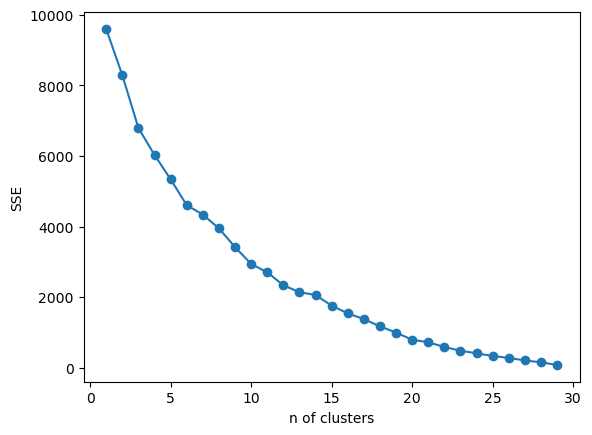

In [ ]:
def elbow(X) :
    sse = []
    
    for i in range(1, 30) :
        km = KMeans(n_clusters = i, init = "k-means++", random_state = 42)
        km.fit(X)
        sse.append(km.inertia_)
        
    plt.plot(range(1, 30), sse, marker = "o")
    plt.xlabel('n of clusters')
    plt.ylabel('SSE')
    plt.show()
    
elbow(df_cluster)

> 대충 6개 정도...?

In [ ]:
km = KMeans(n_clusters = 6, init = "k-means++", random_state = 42, max_iter = 1000)
km.fit(df_cluster)
cluster = km.predict(df_cluster)
result_cluster = pd.DataFrame({"build_num" : [str(i) for i in range(1, 101)], "cluster" : cluster}).assign(build_num = lambda _df : _df.build_num.astype("category"))

In [222]:
df_train = pd.merge(df_train, result_cluster)
df_test = pd.merge(df_test, result_cluster)

In [9]:
set(df_train.columns) - set(df_test.columns)

{'power', 'sunhour', 'sunweight'}

In [ ]:
# add aggregate(mean) target feature for 'cluster', 'building', 'mgrp' per date
def add_feats(df):
    df.reset_index(drop=True, inplace=True)

    cols = ['target']
    stats = ['mean']

    # target null in test set to null for other columns care must be taken
    g = df.groupby(['date', 'cluster'])
    for s in stats:
        col_mapper = {c:f"{s}_{c}_cluster" for c in cols}
        tr = g[cols].transform(s).rename(col_mapper, axis=1)
        df = pd.concat([df, tr], axis=1)

    g = df.groupby(['date', 'num'])
    for s in stats:
        col_mapper = {c:f"{s}_{c}_num" for c in cols}
        tr = g[cols].transform(s).rename(col_mapper, axis=1)
        df = pd.concat([df, tr], axis=1)

    g = df.groupby(['date', 'mgrp'])
    for s in stats:
        col_mapper = {c:f"{s}_{c}_mgrp" for c in cols}
        tr = g[cols].transform(s).rename(col_mapper, axis=1)
        df = pd.concat([df, tr], axis=1)

    g = df.groupby(['date'])
    for s in stats:
        col_mapper = {c:f"{s}_{c}" for c in cols}
        tr = g[cols].transform(s).rename(col_mapper, axis=1)
        df = pd.concat([df, tr], axis=1)

    return df

# interpolate NA values in test dataset
def interpolate_(test_df):
    # https://dacon.io/competitions/official/235736/codeshare/2844?page=1&dtype=recent
    # 에서 제안된 방법으로
    __methods = {
        'temperature': 'quadratic',
        'windspeed':'linear',
        'humidity':'quadratic',
        'precipitation':'linear',
        'insolation': 'pad'
    }

    for col, method in __methods.items():
        test_df[col] = test_df[col].interpolate(method=method)
        if method == 'quadratic':
            test_df[col] = test_df[col].interpolate(method='linear')

# prepare train and test data
def prep():

    train_df, test_df = __read_df()

    # get nelec_cool_flag and solar_flag from training data
    test_df = test_df.drop(['nelec_cool_flag','solar_flag'], axis=1)
    test_df = test_df.merge(train_df.groupby("num").first()[['nelec_cool_flag','solar_flag']].reset_index(), on="num", how="left")

    # interpolate na in test_df for temperature, windspeed, humidity, precipitation & insolation
    interpolate_(test_df)

    # FEATURE(mgrp): group buildings having same temperature and windspeed measurements
    s = train_df[train_df.datetime=='2020-06-01 00:00:00'].groupby(['temperature', 'windspeed']).ngroup()
    s.name = 'mgrp'
    mgrps = train_df[['num']].join(s, how='inner')

    sz = train_df.shape[0]

    df = pd.concat([train_df, test_df])
    df = df.merge(mgrps, on='num', how='left')

    # add aggregate target features
    df = add_feats(df)

    # add log target
    df["log_target"] = np.log(df.target + 1e-8)

    for col in CATE_COLS:
        df[col] = df[col].astype(str).astype('category')

    # add time index feature
    __ix = df.columns.get_loc('datetime')
    df['time_idx'] = (df.loc[:, 'datetime'] - df.iloc[0, __ix]).astype('timedelta64[h]').astype('int')

    train_df = df.iloc[:sz].copy()
    test_df = df.iloc[sz:].copy()

    return train_df, test_df

# build traind datset
def load_dataset(train_df, validate=False):

    max_encoder_length = 24*7*ENCODER_LENGTH_IN_WEEKS # use 5 past weeks
    max_prediction_length = 24*7 # to predict 1 week of future
    training_cutoff = train_df["time_idx"].max() - max_prediction_length

    # build training dataset
    tr_ds = TimeSeriesDataSet(
        # with validate=False use all data
        train_df[lambda x: x.time_idx <= training_cutoff] if validate else train_df,
        time_idx="time_idx",
        target="target",
        group_ids=["num"],
        min_encoder_length=1,
        max_encoder_length=max_encoder_length,
        min_prediction_length=1,
        max_prediction_length=max_prediction_length,
        time_varying_known_categoricals=CATE_COLS,
        static_categoricals=["num", "mgrp", "cluster"],
        time_varying_known_reals=[
            "time_idx",
            'hour',
            "temperature",
            "windspeed",
            "humidity",
            "precipitation",
            "insolation",
            'cumhol'
        ],
        target_normalizer=GroupNormalizer(groups=["num"], transformation="softplus"),
        time_varying_unknown_categoricals=[],
        time_varying_unknown_reals=[
            "target",
            "log_target",
            "mean_target",
            "mean_target_num",
            "mean_target_mgrp",
            "mean_target_cluster"
        ],
        add_relative_time_idx=True,  # add as feature
        add_target_scales=True,  # add as feature
        add_encoder_length=True,  # add as feature
    )

    va_ds = None
    if validate:
        # validation dataset not used for submission
        va_ds = TimeSeriesDataSet.from_dataset(
            tr_ds, train_df, predict=True, stop_randomization=True
        )

    return tr_ds, va_ds

# training
def fit(seed, tr_ds, va_loader=None):
    seed_all(seed) # doesn't really work as training is non-deterministic

    # create dataloaders for model
    tr_loader = tr_ds.to_dataloader(
        train=True, batch_size=BATCH_SIZE, num_workers=12
    )

    if va_loader is not None:
        # stop training, when loss metric does not improve on validation set
        early_stopping_callback = EarlyStopping(
            monitor="val_loss",
            min_delta=1e-4,
            patience=20,
            verbose=True,
            mode="min"
        )
        lr_logger = LearningRateMonitor(logging_interval="epoch")  # log the learning rate
        callbacks = [lr_logger, early_stopping_callback]
    else:
        # gather 10 checkpoints with best traing loss
        checkpoint_callback = ModelCheckpoint(
            monitor='train_loss',
            dirpath=CKPTROOT,
            filename=f'seed={seed}'+'-{epoch:03d}-{train_loss:.2f}',
            save_top_k=10
        )
        callbacks = [checkpoint_callback]

    # create trainer
    trainer = pl.Trainer(
        max_epochs=args.nepochs,
        gpus=[args.gpu],
        gradient_clip_val=PARAMS['gradient_clip_val'],
        limit_train_batches=30,
        callbacks=callbacks,
        logger=TensorBoardLogger(LOGDIR)
    )

    # use pre-deterined leraning rate schedule for final submission
    learning_rate = LRS if va_loader is None else PARAMS['learning_rate']

    # initialise model with pre-determined hyperparameters
    tft = TemporalFusionTransformer.from_dataset(
        tr_ds,
        learning_rate=learning_rate,
        hidden_size=PARAMS['hidden_size'],
        attention_head_size=PARAMS['attention_head_size'],
        dropout=PARAMS['dropout'],
        hidden_continuous_size=PARAMS['hidden_continuous_size'],
        output_size=1,
        loss=SMAPE(), # SMAPE loss
        log_interval=10,  # log example every 10 batches
        logging_metrics=[SMAPE()],
        reduce_on_plateau_patience=4,  # reduce learning automatically
    )
    print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

    kwargs = {'train_dataloader': tr_loader}
    if va_loader:
        kwargs['val_dataloaders'] = va_loader

    # fit network
    trainer.fit(
        tft,
        **kwargs
    )

    best_model_path = trainer.checkpoint_callback.best_model_path
    print(f"{best_model_path=}")
    best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

    return best_tft

# predict 1 week
def forecast(ckpt, train_df, test_df):
    # load model
    best_tft = TemporalFusionTransformer.load_from_checkpoint(ckpt)
    max_encoder_length = best_tft.dataset_parameters['max_encoder_length']
    max_prediction_length = best_tft.dataset_parameters['max_prediction_length']

    assert max_encoder_length == 5*24*7 and max_prediction_length == 1*24*7

    # use 5 weeks of training data at the end
    encoder_data = train_df[lambda x: x.time_idx > x.time_idx.max() - max_encoder_length]

    # get last entry from training data
    last_data = train_df.iloc[[-1]]

    # fill NA target value in test data with last values from the train dataset
    target_cols = [c for c in test_df.columns if 'target' in c]
    for c in target_cols:
        test_df.loc[:, c] = last_data[c].item()

    decoder_data = test_df

    # combine encoder and decoder data. decoder data is to be predicted
    new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)
    new_raw_predictions, new_x = best_tft.predict(new_prediction_data, mode="raw", return_x=True)

    # num_labels: mapping from 'num' categorical feature to index in new_raw_predictions['prediction']
    #             {'5': 4, '6': 6, ...}
    # new_raw_predictions['prediction'].shape = (60, 168, 1)
    num_labels = best_tft.dataset_parameters['categorical_encoders']['num'].classes_

    preds = new_raw_predictions['prediction'].squeeze()

    sub_df = pd.read_csv(DATAROOT/"sample_submission.csv")

    # get prediction for each building (num)
    for n, ix in num_labels.items():
        sub_df.loc[sub_df.num_date_time.str.startswith(f"{n} "), 'answer'] = preds[ix].numpy()

    # save predction to a csv file
    outfn = CSVROOT/(Path(ckpt).stem + '.csv')
    print(outfn)
    sub_df.to_csv(outfn, index=False)

def ensemble(outfn):
    # get all prediction csv files
    fns = list(CSVROOT.glob("*.csv"))
    df0 = pd.read_csv(fns[0])
    df = pd.concat([df0] + [pd.read_csv(fn).loc[:,'answer'] for fn in fns[1:]], axis=1)
    # get median of all predcitions
    df['median'] = df.iloc[:,1:].median(axis=1)
    df = df[['num_date_time', 'median']]
    df = df.rename({'median': 'answer'}, axis=1)
    # save to submission file
    df.to_csv(outfn, index=False)

# not used for final submission
def validate(seed, tr_ds, va_ds):
    va_loader = va_ds.to_dataloader(
        train=False, batch_size=BATCH_SIZE*10, num_workers=12
    )
    best_tft = fit(seed, tr_ds, va_loader)
    actuals = torch.cat([y[0] for x, y in iter(va_loader)])
    predictions = best_tft.predict(va_loader)
    smape_per_num = SMAPE(reduction="none")(predictions, actuals).mean(1)
    print(smape_per_num)
    print(smape_per_num.mean())

if __name__ == "__main__":
    [p.mkdir(exist_ok=True) for p in (CKPTROOT, CSVROOT, LOGDIR)]

    train_df, test_df = prep()
    tr_ds, va_ds = load_dataset(train_df, args.val)

    if args.val:
        validate(args.seed[0], tr_ds, va_ds)
    else:
        if args.fit:
            print("### FIT ###")
            for s in args.seed:
                fit(s, tr_ds)

        if args.forecast:
            print("### FORECAST ###")
            for p in CKPTROOT.glob("*.ckpt"):
                forecast(p, train_df, test_df)

            print("### ENSEMBLING ###")
            ensemble(SUBFN)
